# L11: sqrt SAM, Factorization Example
In this notebook we will create a toy example for a Factor Graph via its adjacency matrix and different factorizations

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [6]:
A

array([[0.82083687, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06008165, 0.67630047, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.67687046, 1.3966073 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

1) The first step is to create a random adjacency matrix $A$ and the residual vector $b$ such that $Ax=b$ and the normal equation from the adjacency matrix $A$, $\Lambda = A^{\top}A$

Number of observations Z = 50 Zi = [3 3 2 1 1 3 2 1 1 3 3 3 3 2 2 2 2 1 2 1 3 2 1 3 2 1 2 1 2 1 1 2 3 3 2 3 1
 3 3 2 1 1 1 3 1 1 2 2 2 1]
Order of landmark observations = [32 42 30 17 38 20  5 27  1 24  3 36  4 29 35 21 28 45 43 11 34 33 49 39
  9 46 13 48 37 14 12 19 44  0 15 10  6 26 40  7 18 23 31 41  2 22 47 25
 16  8]


'non zero elements in A = '

287

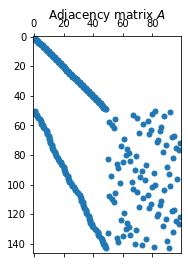

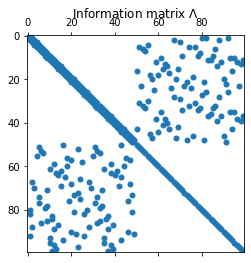

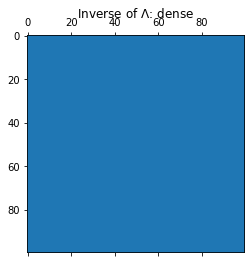

In [3]:
N = 50 #number of poses
M = N  #number of landmarks
num_z = np.random.randint(1,4*round(N/M), M) 
print("Number of observations Z =", num_z.size, "Zi =", num_z)
A = np.zeros((np.sum(num_z)+N,N+M)) # generate adjacency matrix

# Odometry chain: 1D-Jacobians are random noise at selected points, keeping the A structure
A[0,0] = np.random.rand() # prior x_0^0
for t in range(1,N):
    A[t,t] = np.random.randn() # put residual \delta on diagonal
    A[t,t-1] = np.random.rand() # put random Jacobians of motion on [t,t-1] (see lecture L10.8)
    
# Landmark observations
index_k = 0
k_z = np.random.permutation(M)
print("Order of landmark observations =", k_z)
for t in range(1,N):
    for i in range(num_z[t]):
        A[N + index_k + i , t] = np.random.rand() # Jacobian respect to observation
        A[N + index_k + i , N + k_z[(index_k+i)%M] ] = np.random.rand() # Jacobian respect to landmark
    index_k += num_z[t]

# ----- plotting -----
plt.figure(1)
plt.spy(A, marker='o', markersize=5)
plt.title('Adjacency matrix $A$')
display('non zero elements in A = ',np.count_nonzero(A))
plt.figure(2)
Lambda = np.transpose(A) @ A # + np.eye(N+M)*0.001
plt.spy(Lambda, marker='o', markersize=5)
plt.title('Information matrix $\Lambda$')
plt.figure(3)
plt.spy(np.linalg.inv(Lambda), marker='o', markersize=5)
plt.title('Inverse of $\Lambda$: dense')
plt.show()

## Raw Cholesky factorization $\Lambda = A^{\top}A$ and $R = Cholesky(\Lambda)$

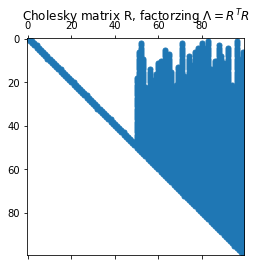

3248

In [10]:
R = la.cholesky(Lambda, lower=False)
plt.figure(4)
plt.spy(R,marker='o', markersize=5)
plt.title('Cholesky matrix R, factorzing $\Lambda = R^{T}R$')
plt.show()
np.count_nonzero(R)

## Raw QR factorization $A = QR$

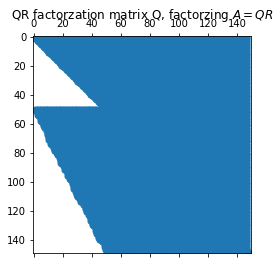

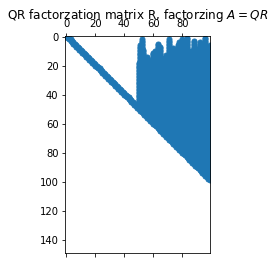

3248

In [12]:
Q, R_ = la.qr(A,mode='full')

plt.figure(5)
plt.spy(Q,marker='o', markersize=5)
plt.title('QR factorzation matrix Q, factorzing $A = QR$')
plt.show()

plt.figure(5)
plt.spy(R_,marker='o', markersize=5)
plt.title('QR factorzation matrix R, factorzing $A = QR$')
plt.show()
np.count_nonzero(R_)

## Raw Schur complement $M^{-1} = \Lambda_x - \Lambda_{x,m} \Lambda_m^{-1} \Lambda_{m,x}$

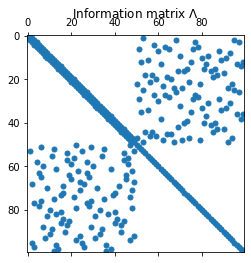

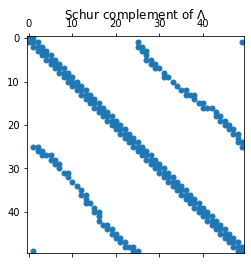

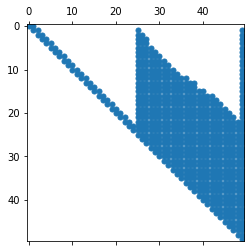

707

In [5]:
L_x = Lambda[:N,:N]
L_xm = Lambda[:N, N:]
L_mx = np.transpose(L_xm)
L_m = Lambda[N:,N:]
Sch = L_x - L_xm @ np.linalg.inv(L_m) @ L_mx #the inversion could be more efficient since it is diagonal
plt.figure()
plt.spy(Lambda, marker='o', markersize=5)
plt.title('Information matrix $\Lambda$')
plt.figure()
plt.spy(Sch,marker='o', markersize=5)
plt.title('Schur complement of $\Lambda$')
R_1 = la.cholesky(Sch, lower=False)
plt.figure()
plt.spy(R_1,marker='o', markersize=5)
plt.show()
np.count_nonzero(R_1)

## Reordering Cholesky factorization
In Python, scikit-sparse cholmod does this for you automatically. For this example I will use a matrix permutation direcltly ordering number of components. Still we should get less fill-ins on the resultant matrices R

In [14]:
def colperm(A):
    "Column permutation by minimum number of elements"
    S = np.count_nonzero(A,axis=0)
    P = np.argsort(S) # sorted (примитивная эвристика, одна она поможет)
    return P

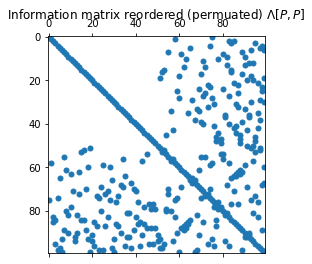

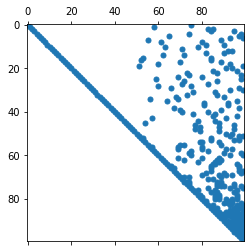

377

In [15]:
P = colperm(A)
A_o = A[:,P]
plt.figure()
Lambda_o = np.transpose(A_o) @ A_o
plt.spy(Lambda_o,marker='o', markersize=5)
plt.title('Information matrix reordered (permuated) $\Lambda[P,P]$')
plt.figure()
R_o = la.cholesky(Lambda_o, lower=False)
plt.spy(R_o,marker='o', markersize=5)
plt.show()
np.count_nonzero(R_o)

### Reordering помог значительно (смотри предыдущий Cholecky factorisation)

## Reordering the QR factorization

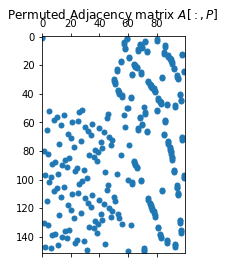

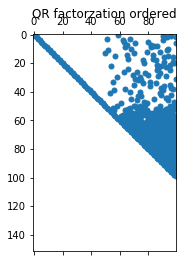

995

In [8]:
plt.figure()
plt.spy(A_o,marker='o', markersize=5)
plt.title('Permuted Adjacency matrix $A[:,P]$')
Q, R_o_ = la.qr(A_o,mode='full')
plt.figure()
plt.spy(R_o_,marker='o', markersize=5)
plt.title('QR factorzation ordered')
plt.show()
np.count_nonzero(R_o_)

## Reordering Schur complement

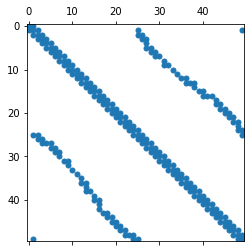

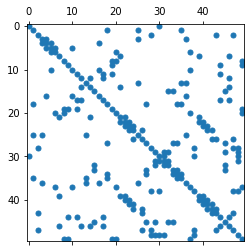

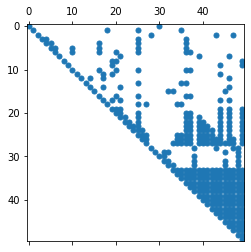

363

In [9]:
plt.figure()
plt.spy(Sch,marker='o', markersize=5)
plt.figure()
P_s = colperm(Sch)
#Sch_o = Sch[P_s,P_s] #TODO this doesnt work
Sch_oi = Sch[:,P_s]
Sch_o = Sch_oi[P_s,:]
plt.spy(Sch_o, marker='o', markersize=5)
Sch_o.size
R_1_o = la.cholesky(Sch_o, lower=False)
plt.figure()
plt.spy(R_1_o,marker='o', markersize=5)
plt.show()
np.count_nonzero(R_1_o)